# COGS 182 Homework 8
Malachi Mabie

## Intro

For this HW we will be coding up Dyna-Q and Prioritized Sweeping for the following 10x10 grid world.

In this environment, there are 100 states and 4 possible actions: right, up, left, and down. The goal of the agent is to move, via a series of steps, from the start (green) location to the goal (yellow) region, while avoiding the red walls. More specifically:

The agent starts in the green state,
Moving into one of the red states incurs a reward of -1,
Moving into the world borders stays in the same place,
Moving into the goal state (yellow square in the upper right corner) gives you a reward of 1, and
Moving anywhere from the goal state ends the episode.

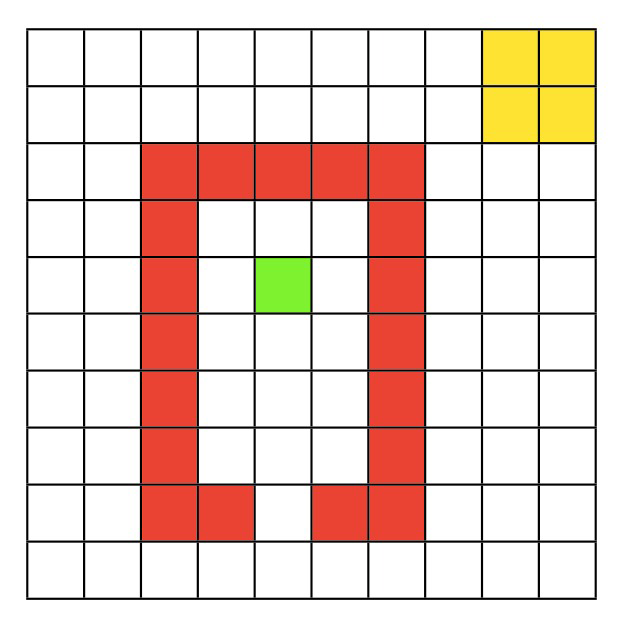

## 1. (5 points)
Use Dyna-Q to solve the grid world. Create a plot like in Figure 8.2 that shows the steps per episode as a function of the number of episodes for [0,1,10,100] planning steps. [alpha = 0.5, gamma = 0.8, epsilon = 0.05] 

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import heapq
from scipy.signal import convolve as conv


In [66]:
# Helper Print Functions

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')
    
def plot_quiver_max_action(env, value, ax=None):
  """
  Generate plot showing action of maximum value or maximum probability at
    each state (not for n-armed bandit or cheese_world).
  """
  if ax is None:
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x), [env.dim_y,1]) + 0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis], [1,env.dim_x]) + 0.5
  which_max = np.reshape(value.argmax(axis=1), (env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(X.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X, Y, U, V)
  ax.set(
      title='Maximum value/probability actions',
      xlim=[-0.5, env.dim_x+0.5],
      ylim=[-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x, env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')

def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none',cmap='cividis')#, cmap='afmhot'
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im

In [ ]:
# The GridWorld Environment
class world(object):
    def __init__(self):
        return

    def get_outcome(self):
        print("Abstract method, not implemented")
        return

    def get_all_outcomes(self):
        outcomes = {}
        for state in range(self.n_states):
            for action in range(self.n_actions):
                next_state, reward = self.get_outcome(state, action)
                outcomes[state, action] = [(1, next_state, reward)]
        return outcomes

class GridWorld(world):
    """
    World: Quentin's world.
    100 states (10-by-10 grid world).
    The mapping from state to the grid is as follows:
    90 ...       99
    ...
    40 ...       49
    30 ...       39
    20 21 22 ... 29
    10 11 12 ... 19
    0  1  2  ...  9
    54 is the start state.
    Actions 0, 1, 2, 3 correspond to right, up, left, down.
    Moving anywhere from state 99 (goal state) will end the session.
    Landing in red states incurs a reward of -1.
    Landing in the goal state (99) gets a reward of 1.
    Going towards the border when already at the border will stay in the same
        place.
    """
    def __init__(self):
        self.name = "QuentinsWorld"
        self.n_states = 100
        self.n_actions = 4
        self.dim_x = 10
        self.dim_y = 10
        self.init_state = 54
        self.shortcut_state = 64

    def toggle_shortcut(self):
      if self.shortcut_state == 64:
        self.shortcut_state = 2
      else:
        self.shortcut_state = 64

    def get_outcome(self, state, action):
        if state == 99:  # goal state
            reward = 0
            next_state = None
            return next_state, reward
        reward = 0  # default reward value
        if action == 0:  # move right
            next_state = state + 1
            if state == 98:  # next state is goal state
                reward = 1
            elif state % 10 == 9:  # right border
                next_state = state
            elif state in [11, 21, 31, 41, 51, 61, 71,
                           12, 72,
                           73,
                           14, 74,
                           15, 25, 35, 45, 55, 65, 75]:  # next state is red
                reward = -1
        elif action == 1:  # move up
            next_state = state + 10
            if state == 89:  # next state is goal state
                reward = 1
            if state >= 90:  # top border
                next_state = state
            elif state in [2, 12, 22, 32, 42, 52, 62,
                           3, 63,
                           self.shortcut_state,
                           5, 65,
                           6, 16, 26, 36, 46, 56, 66]:  # next state is red
                reward = -1
        elif action == 2:  # move left
            next_state = state - 1
            if state % 10 == 0:  # left border
                next_state = state
            elif state in [17, 27, 37, 47, 57, 67, 77,
                           16, 76,
                           75,
                           14, 74,
                           13, 23, 33, 43, 53, 63, 73]:  # next state is red
                reward = -1
        elif action == 3:  # move down
            next_state = state - 10
            if state <= 9:  # bottom border
                next_state = state
            elif state in [22, 32, 42, 52, 62, 72, 82,
                           23, 83,
                           84,
                           25, 85,
                           26, 36, 46, 56, 66, 76, 86]:  # next state is red
                reward = -1
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state) if next_state is not None else None, reward

In [ ]:
def run_episode_dynaQ(env, q_values, model, alpha, gamma, epsilon, n_planning_steps, max_steps):
    
    state = env.init_state
    steps = max_steps
    
    for t in range(max_steps):
        
        # Select action based on epsilon greedy
        p = np.random.random()
        if p < epsilon:
          # epsilon
          action = np.random.choice([0,1,2,3])
        else:
          # greedy
          action = np.argmax(q_values[state])

        # Use env.get_outcome() to get next state and reward
        state_next, r = env.get_outcome(state,action)
        
        # Store the transition in your model array
        model[state, action] = state_next, r
        # Update q_values using q learning

        q_values[state,action] += alpha*(r + 
                                         gamma*np.argmax(q_values[state_next])
                                          - q_values[state,action])


        # Iterate over the n planning steps
        for k in range(n_planning_steps):
            
            # Create an array of the candidate states to update
            candidates = np.array(np.where(~np.isnan(model[:,:,0]))).T 
            
            idx = np.random.choice(len(candidates))
            
            state_p, action_p      = candidates[idx]
            
            # Use your model to find the next state and reward
            state_next_p, r_p = model[state_p, action_p]
            state_next_p = int(state_next_p)
            # Update q values using q learning
            
            q_values[state_p, action_p] += alpha*(r_p 
                                                  + gamma*np.argmax(q_values[state_next_p])
                                                  - q_values[state_p,action_p] )
            
        
        #Break if the episode is over
        if state_next == None:
            steps = t
            break
        state = state_next
    
    return q_values, model, steps

In [ ]:
# Parameters
alpha = 0.5
gamma = 0.8
epsilon = 0.05
n_planning_steps= [0,1,10,20,50]
n_episodes = 50
n_experiments = 100 # Can increase to 100 to make your plots nicer
max_steps = 1000

# Create an environment 
env = GridWorld()

# Store the number of steps until the goal for a given episode
steps_per_episode = np.zeros((len(n_planning_steps), n_experiments, n_episodes))

q_values = []


for i , k_steps in enumerate(n_planning_steps):
    
    for j in range(n_experiments):
        
        # Stores model of reward and next state
        model = np.nan*np.zeros([env.n_states, env.n_actions, 2])
        q_values = np.ones([env.n_states, env.n_actions])

        for l in range(n_episodes):

            # Run DynaQ on an episode of GridWorld
            q_values, model, steps = run_episode_dynaQ(env, q_values, model, alpha, gamma, epsilon, k_steps, max_steps) 
            
            steps_per_episode[i,j,l] = steps

Text(0.5, 0, 'Episodes')

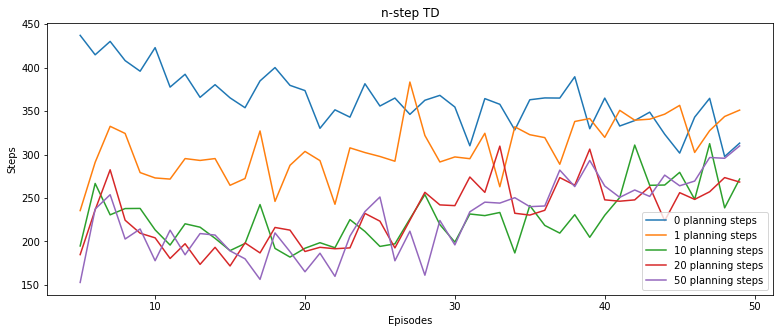

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,5))

for i , k_steps in enumerate(n_planning_steps):
    
    ax.plot(range(5,50), np.mean(steps_per_episode[i,:,5:50], axis=(0)).T, label = str(n_planning_steps[i]) + " planning steps" )
    
ax.legend()
ax.title.set_text("n-step TD")
ax.set_ylabel("Steps")
ax.set_xlabel("Episodes")

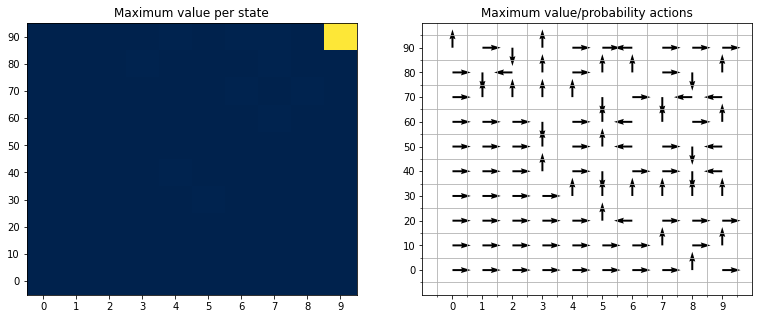

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

plot_heatmap_max_val(env, q_values, ax[0])
plot_quiver_max_action(env, q_values, ax[1])



## 2. (1 point)
How would you modify the code for your tabular Dyna-Q algorithm to handle stochastic environments?  How might this modification perform poorly in changing environments?




> I would have it renew its model over the previously explored areas every some number of iterations, to keep track of stochastic changes. This would greatly slow down the rate of learning, since we would have basic uncertainty that makes what we've previously learned insecure. If we received signals about these stochastic changes, we could integrate prioritized sweeping rather than stochastic sweeping.



## 3. (2 points)
What are two reasons that we need to explicitly define an objective function when using function approximation?



> - The objective function gives us feedback on what to optimize to. For example, using Mean Squared Error as a function tells us how approximate our result is. If it isn't explicit there is no gradient.
- The objective function also needs to be explicit because some states may be more important than others, and the objective function is what codes that in to the supervized learning algorithm.



## 4. (2 points)
Show that tabular methods such as presented in Part I of this book are a special case of linear function approximation. What would the feature vectors be?



> In the tabular case, state values are decoupled. This means each state will end up as its own feature vector in linear function approximation.

